# Trabajo práctico: Redes Neuronales Artificiales
El objetivo del presente trabajo es desarrollar una red neuronal artificial de tipo backpropagation para la clasificación de cinco aves arbitrariamente definidas por el equipo desarrollador del proyecto.

# Importa bibliotecas

In [56]:
import matplotlib.pyplot as plt     # permite visualizar imágenes del dataset
import pandas as pd                 # para visualizar en gráficos los datos del entrenamiento del modelo
import numpy as np                  # provee sus propios tipos de datos como array y es usado por tensorflow para manejar los datos
import tensorflow as tf             # tecnología de bajo nivel para crear la RNA
from tensorflow import keras        # tecnología de alto nivel para crear la RNA, es parte de tensorflow
from keras import layers            # namespace de keras para el manejo de las distintas capas de la RNA
import seaborn as sns               # permite crear heatmaps y visualizarlos
from sklearn.metrics import classification_report, confusion_matrix # provee métricas para las predicciones
import os

# Define detalles sobre nuestro dataset

In [57]:
image_width = 224 
image_heigth = 224
image_size = (image_width, image_heigth)  
batch_size = 32  # es la cantidad de fotos que incluir en cada batch_dataset

# Procesa el dataset y define los nombres de nuestras clases

In [58]:
data_dir = "dataset/"

def get_ds(path):
  return tf.keras.preprocessing.image_dataset_from_directory(
        data_dir + path,
        image_size=image_size,
        batch_size=batch_size,
        labels="inferred")

train_ds = get_ds("train")
valid_ds = get_ds("valid")
test_ds = get_ds("test")

# Keras le asigna un int a cada clase que encuentra: 0 a la primera, 1 a la segunda, etc.
# El array de nombres tiene que estar en el mismo orden en el que keras encuentra las clases
class_names = sorted(os.listdir('dataset/train'))

Found 70626 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.
Found 2250 files belonging to 450 classes.


# Muestra una selección de imágenes del dataset junto al nombre de su clase

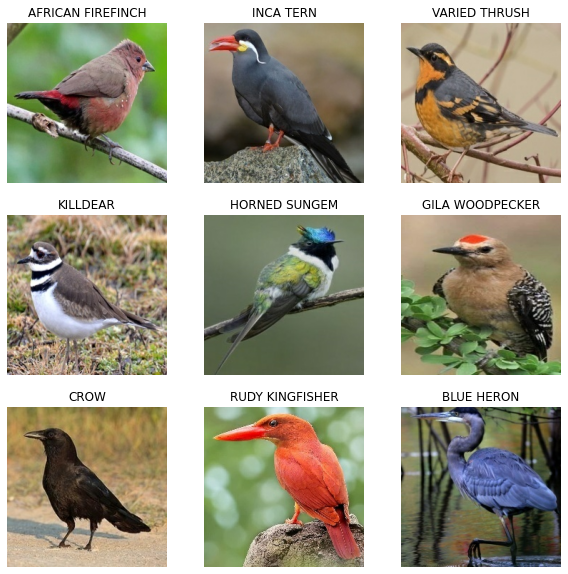

In [60]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.show()

# Separa en imágenes y labels los 3 datasets

In [ ]:
def get_images_and_labels(dataset):
  _images = []
  _labels = []

  for images, labels in dataset:
    for img in images:
      # img es un EagerTensor de forma (224, 224, 3), para obtenerlo como array hay que llamar al método numpy(),
      # que devuelve la info dentro del EagerTensor como un numpy.array
      _images.append(img.numpy())

    for label in labels:
      # label es un EagerTensor de forma () <es solo un número>, para obtenerlo como número se lo envuelve en la
      # función int(), que devuelve el label como un simple número
      _labels.append(int(label))
  
  # Convierte los arrays a numpy.arrays porque tensorflow los necesita así.
  # Al de labels le pasa el dtype porque no lo puede inferir, 
  # np.int32 es el mismo dtype que tenía antes de destructurar el dataset
  return np.array(_images), np.array(_labels, dtype=np.int32)

train_images, train_labels = get_images_and_labels(train_ds)
valid_images, valid_labels = get_images_and_labels(valid_ds)
test_images, test_labels = get_images_and_labels(test_ds)

# Normaliza el dataset
Cada píxel de cada imagen en los arrays se compone por 3 valores que van de 0 a 255. Para que el modelo no tarde mucho tiempo en converger a una solución se suele reescalar las características para que los valores vayan de 0 a 1. Por eso se divide por 255.0.

In [ ]:
train_images = train_images / 255.0
valid_images = valid_images / 255.0
test_images = test_images / 255.0

# Crea el modelo
Definimos este modelo con 6 capas, de las cuales las 4 centrales son de 300, 100, 100 y 100 respectivamente. La función "relu" de activación devuelve el máximo entre 0 y un valor.

In [ ]:
# si existe el checkpoint del modelo lo carga, si no existe lo crea 
try:
  model_marcos = keras.models.load_model('model_marcos.h5')
except:
  model_marcos = keras.models.Sequential([
                layers.Flatten(input_shape = [image_width, image_heigth, 3]),    
                layers.Dense(300, activation = "relu"),                          
                layers.Dense(100, activation = "relu"),                          
                layers.Dense(100, activation = "relu"),                          
                layers.Dense(100, activation = "relu"),                          
                layers.Dense(5, activation = "softmax")                          
  ])

# Compila el modelo

In [ ]:
model_marcos.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

# Entrena el modelo
Decidimos entrenar este modelo con 200 epochs para ver a cuánto puede llegar la precisión si el modelo se entrena mucho.

In [ ]:
history_marcos = model_marcos.fit(train_images,
                    train_labels,
                    epochs = 200,
                    validation_data = (valid_images, valid_labels))

# Guarda el modelo

In [ ]:
model_marcos.save('model_marcos.h5')

# Muestra la evolución de la RNA

In [55]:
pd.DataFrame(history_marcos.history).plot(figsize = (16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

NameError: ignored

# Testea el modelo

## Crea la predicción

In [ ]:
prediction_marcos = model_marcos.predict(test_images)

6/6 [==============================] - 0s 33ms/step


## Muestra la predicción

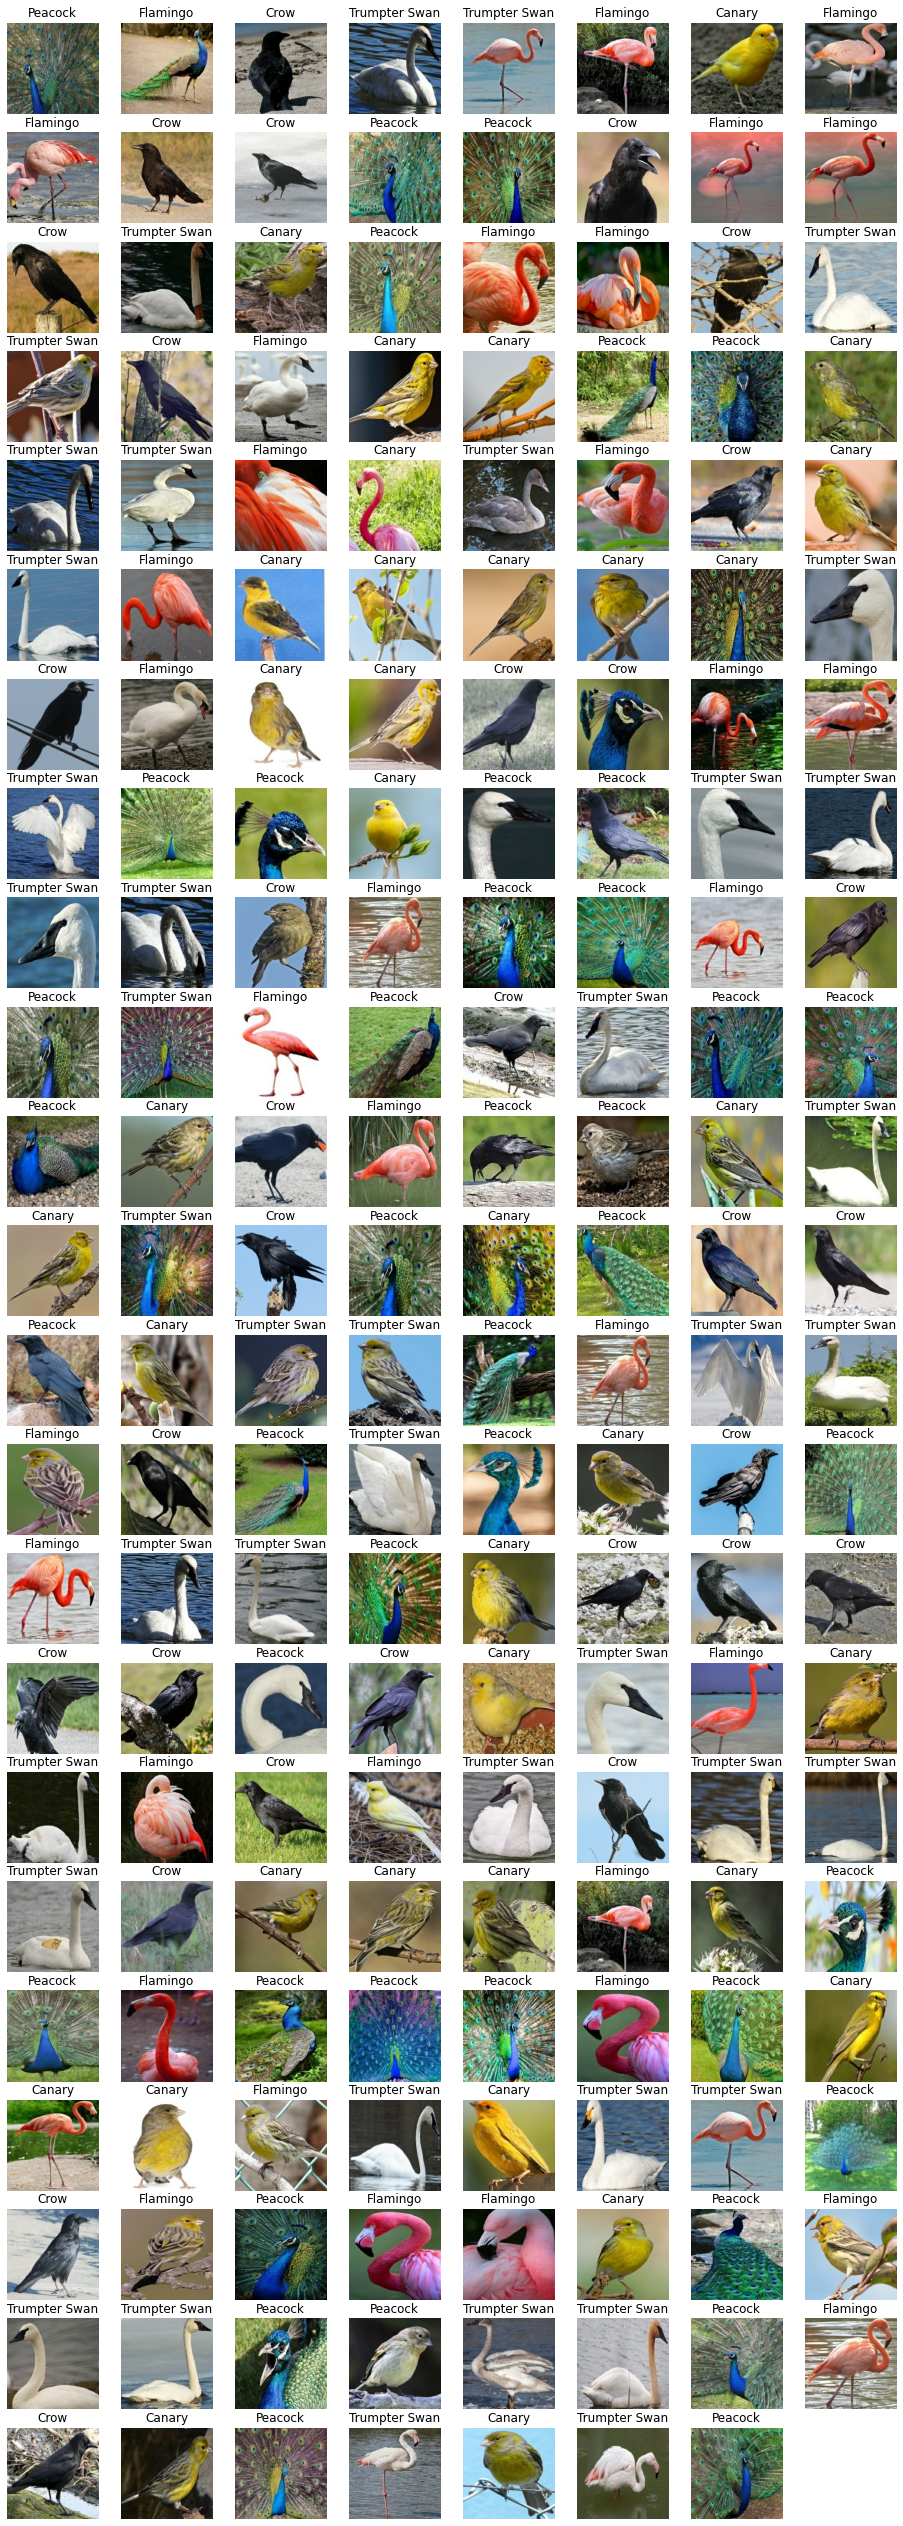

In [ ]:
plt.figure(figsize=(16,62))
for i in range(len(test_labels)):
  plt.subplot(31,8,i+1)
  plt.imshow(test_images[i], cmap=plt.cm.binary)
  plt.title(class_names[prediction_marcos.argmax(axis=-1)[i]])
  plt.axis("off")
plt.show()

## Muestra el reporte de clasificación

In [ ]:
print(classification_report(test_labels, prediction_marcos.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81        42
           1       0.94      0.91      0.92        32
           2       0.76      0.81      0.79        32
           3       0.83      0.85      0.84        41
           4       0.78      0.89      0.83        36

    accuracy                           0.84       183
   macro avg       0.84      0.84      0.84       183
weighted avg       0.84      0.84      0.84       183



## Muestra la matriz de confusión

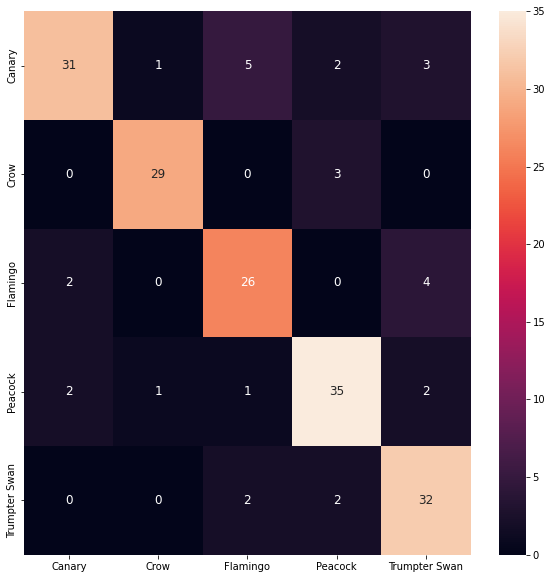

In [ ]:
cm = confusion_matrix(test_labels, prediction_marcos.argmax(axis=-1))
cm = pd.DataFrame(cm, columns=class_names, index=class_names)
plt.figure(figsize = (10,10))

sns.heatmap(cm, annot=True, annot_kws={"size": 12})
plt.show()